## GPLVM - Iris Data

This example uses iris dataset from seaborn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz as az

from toygp import gp, gpx, kernels

In [2]:
jax.config.update('jax_enable_x64', True)

In [3]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

## Generate Keys

In [4]:
keys = jax.random.split(jax.random.PRNGKey(0), num=10)

## Load Data

In [5]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


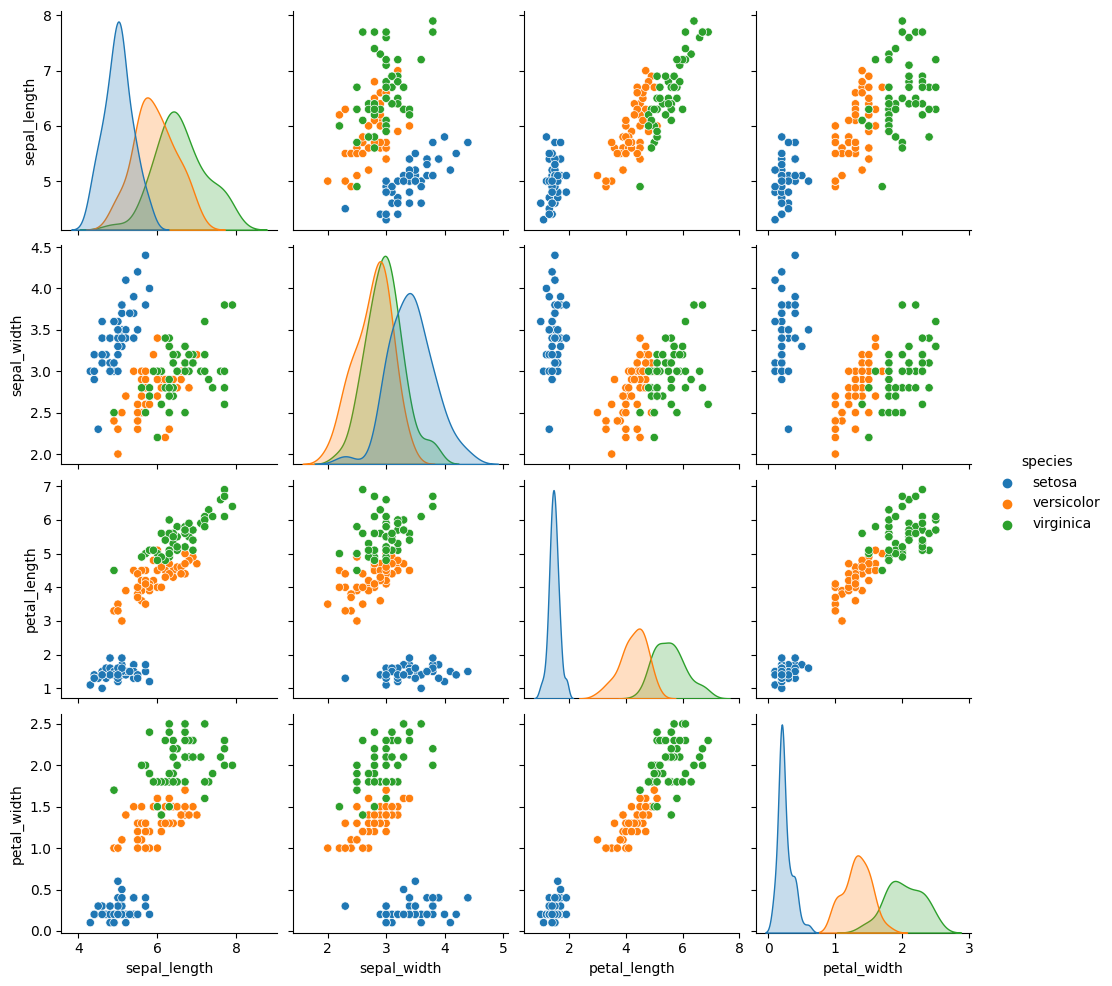

In [6]:
sns.pairplot(df, hue='species')
plt.show()

In [7]:
y = df.iloc[:, :4].to_numpy()
y.shape

(150, 4)

In [8]:
y_mu = jnp.mean(y, axis=0)
y_sd = jnp.std(y, axis=0)

y_scaled = (y - y_mu) / y_sd

## Define Inducing Vectors

In [9]:
ndim_latent = 2
num_inducing_pts = 100

Xu = gp.setup_inducing_normal(keys[0], ndim_latent, num_inducing_pts)

## Define Model

In [10]:
def model(y, xu, ndim_latent):

    num_data = y.shape[0]
    num_feat = y.shape[1]

    #
    # Sample Latent Variable
    #

#    dist_latent = dist.MultivariateNormal(loc=jnp.zeros(ndim_latent), covariance_matrix=jnp.eye(ndim_latent))
    dist_latent = dist.Normal(0, 1).expand([ndim_latent]).to_event(1)
    x_latent = numpyro.sample('x_latent', dist_latent, sample_shape=(num_data,))

    #
    # Define Kernel Function
    #

    rho = numpyro.sample('rho', dist.Gamma(2, 1))
    var = numpyro.sample('var', dist.HalfNormal(10))
    kf = lambda x, y : var * kernels.rbf(x, y, rho)

    #
    # Define GP
    #

    xu_ = numpyro.param('xu', xu)
    noise_sd = numpyro.sample('noise_sd', dist.HalfNormal(10))
    jitter = numpyro.sample('jitter', dist.HalfNormal(1))

    W, D = gpx.sparse_vfe(kf, x_latent, xu_, noise_sd, jitter)
    dist_gp = dist.LowRankMultivariateNormal(loc=jnp.zeros(num_data), cov_factor=W, cov_diag=D)

    #
    # Set Observed Data
    #

    with numpyro.plate('feature', size=num_feat):

        numpyro.sample('obs', dist_gp, obs=y.transpose())


## Inference

In [11]:
guide = numpyro.infer.autoguide.AutoNormal(model)

optimizer = numpyro.optim.Adam(step_size=0.01)
svi = numpyro.infer.SVI(model, guide, optimizer, loss=numpyro.infer.Trace_ELBO())

In [12]:
%%time
svi_result = svi.run(keys[1], 10000, y=y_scaled, xu=Xu, ndim_latent=ndim_latent)

100%|██████████| 10000/10000 [00:33<00:00, 299.52it/s, init loss: 9539.9058, avg. loss [9501-10000]: 635.1575]


CPU times: user 1min 12s, sys: 1min 54s, total: 3min 7s
Wall time: 38 s


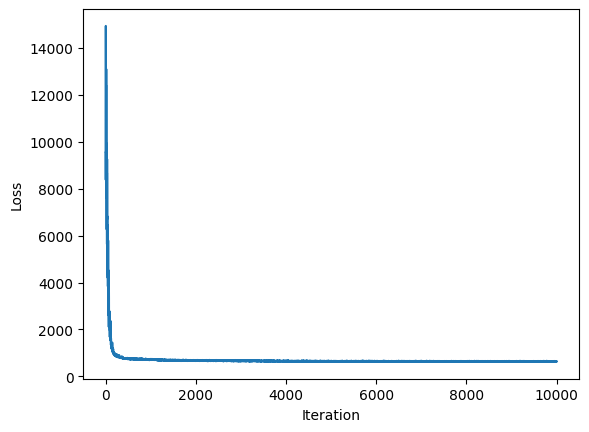

In [13]:
plt.plot(svi_result.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Check Samples

To use arviz's visualization, posterior samples are generated as (2, 1000) to mimic 2-chain MCMC-samples.

In [14]:
posterior_samples = guide.sample_posterior(keys[2], svi_result.params, (2, 1000))
idata = az.from_dict(posterior_samples)

In [15]:
az.summary(idata, var_names=['var', 'rho', 'jitter', 'noise_sd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
var,1.600,0.240,1.188,2.052,0.006,0.004,1684.0,1766.0,1.0
rho,1.202,0.044,1.122,1.285,0.001,0.001,2023.0,2048.0,1.0
jitter,0.003,0.005,0.000,0.009,0.000,0.000,1861.0,1755.0,1.0
noise_sd,0.201,0.006,0.189,0.212,0.000,0.000,2038.0,1965.0,1.0


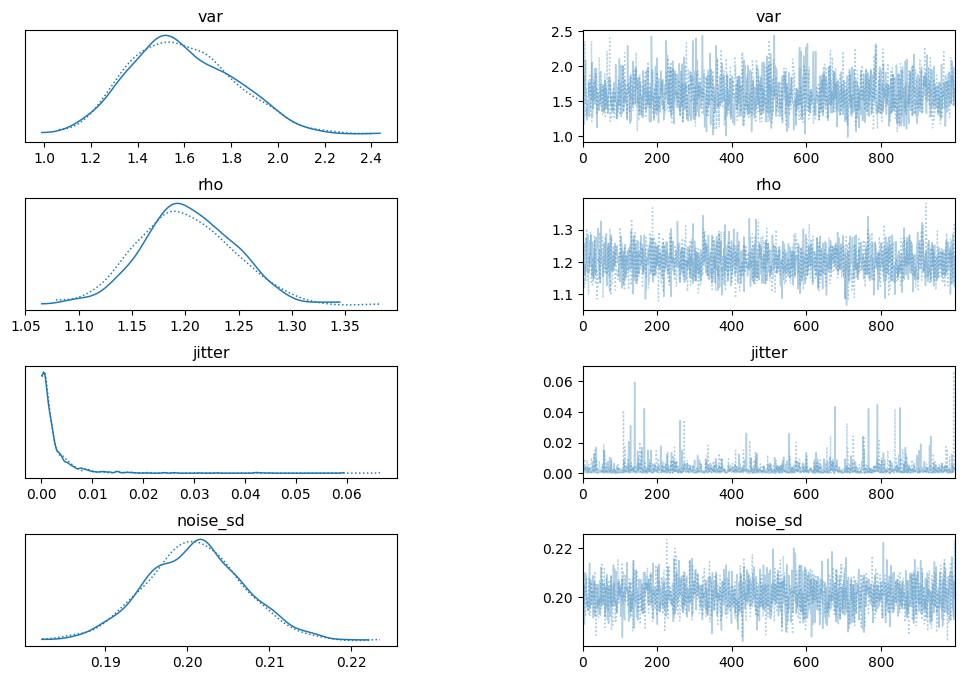

In [16]:
az.plot_trace(idata, var_names=['var', 'rho', 'jitter', 'noise_sd'])
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## Visualize Latent Variables

In [17]:
x_latent = posterior_samples['x_latent'][0, ...]
x_latent = np.mean(x_latent, axis=0)
x_latent.shape

(150, 2)

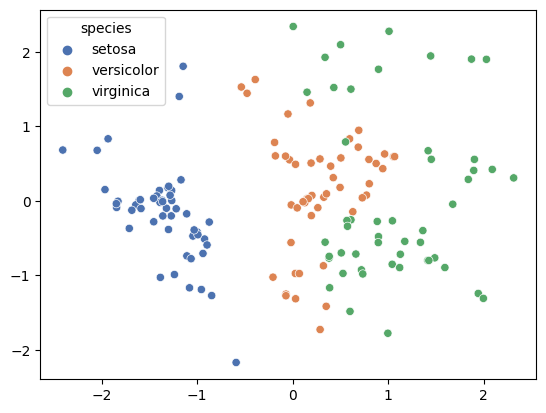

In [18]:
sns.scatterplot(x=x_latent[:, 0], y=x_latent[:, 1], hue=df['species'], palette='deep')
plt.show()